*Assignment 1 Task 1: KNN Regressor*

**Question 1.1: KNN Regressor**

**1.1 Preprocess Diabetes and California Housing Data**

In [73]:
from sklearn.datasets import load_diabetes, fetch_california_housing

diabetes = load_diabetes()
diabetes.data.shape, diabetes.target.shape, diabetes.feature_names
california_housing = fetch_california_housing()

In [75]:
import numpy as np

# Splits data set according to method used in lab
def train_test_split(x, y, train_size=0.6, random_state=None):
    RNG = np.random.default_rng(random_state)
    N = len(x)
    N_train = round(N*train_size)
    idx_train = RNG.choice(N, N_train, replace=False)
    idx_test = np.setdiff1d(np.arange(N), idx_train)
    RNG.shuffle(idx_test)
    x_train = x[idx_train]
    y_train = y[idx_train]
    x_test = x[idx_test]
    y_test = y[idx_test]
    return x_train, x_test, y_train, y_test
    

x_train_diabetes, x_test_diabetes, y_train_diabetes, y_test_diabetes = train_test_split(diabetes.data, diabetes.target, train_size=0.6, random_state=1)
x_train_cali, x_test_cali, y_train_cali, y_test_cali = train_test_split(california_housing.data, california_housing.target, train_size=0.6, random_state=1)

**1.1 KNN Regressor Method**

In [6]:
from sklearn.base import BaseEstimator
from scipy.spatial import KDTree
from scipy.stats import pmean
from sklearn.metrics import mean_squared_error 


class KnnRegressor(BaseEstimator):
    def __init__(self,k):
        self.k = k
        
    def fit(self, x, y):
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        return self
    
    # Predict method adapted from lab, we take the mean of each neighbouring values to compute our current prediction value
    def predict(self, x):
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m = pmean(neighbour_labels, axis=1, keepdims=False, p = 1)
        return m

**Question 1.2: Training using Diabetes dataset**

In [7]:
knn1 = KnnRegressor(3)
knn1.fit(x_train_diabetes,y_train_diabetes)
y_hat_test_diabetes = knn1.predict(x_test_diabetes)

**Question 1.2: Training using California housing dataset**

knn2 = KnnRegressor(3)
knn2.fit(x_train_cali,y_train_cali)
y_hat_test_cali = knn2.predict(x_test_cali)

**Question 1.2: Error Rate for Training and Test Error Calculation**

In [9]:
from sklearn.metrics import mean_squared_error 
import math
def error_rate(y, y_hat):
    error = mean_squared_error(y,y_hat)
    return math.sqrt(error)

**Question 1.2: Error Rate of Diabetes dataset**

In [10]:
y_hat_train_diabetes = knn1.predict(x_train_diabetes)
error_rate(y_train_diabetes, y_hat_train_diabetes), error_rate(y_test_diabetes, y_hat_test_diabetes)

(48.50558333074415, 65.71185841590591)

**Question 1.2: Error Rate of California Housing dataset**

In [11]:
y_hat_train_cali = knn2.predict(x_train_cali)
error_rate(y_train_cali, y_hat_train_cali), error_rate(y_test_cali, y_hat_test_cali)

(0.7560985377778375, 1.121240738220602)

**Question 1.2: Default Bootstrap Splitter CV method adapted from lab, used for testing KNN Regressor Model**

In [12]:
import numpy as np
from sklearn.metrics import make_scorer, mean_squared_error

class BootstrapSplitter:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            N = len(x)
            N_train = round(N*self.train_size)
            train_idx = self.RNG.choice(N, N_train, replace=True)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx

**Question 1.2: Evaluation method adapted from lab, used to evaluate performance of KNN Regressor Diabetes Model**

In [103]:
from sklearn.model_selection import cross_validate

def evaluation(max_k, cv, data, target):
    r = cv.get_n_splits()
    test_results = np.zeros(shape=(r, max_k))
    train_results = np.zeros(shape=(r, max_k))
    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        cv_res = cross_validate(knn,data,target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
        test_results[:, k-1] = cv_res['test_score']
        train_results[:, k-1] = cv_res['train_score']

    return train_results, test_results

In [170]:
def plot (max_k,train_results,test_results):
    ks = np.arange(1, max_k+1)
    _, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
    z = (reps**0.5)/1.96
    axs[0].errorbar(ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
    axs[0].errorbar(ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
    axs[0].legend()
    axs[0].set_xlabel('$k$')
    axs[0].set_ylabel('error rate')
    axs[1].errorbar(1/ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
    axs[1].errorbar(1/ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
    axs[1].set_xscale('log')
    axs[1].set_xlabel('$1/k$')
    plt.show()

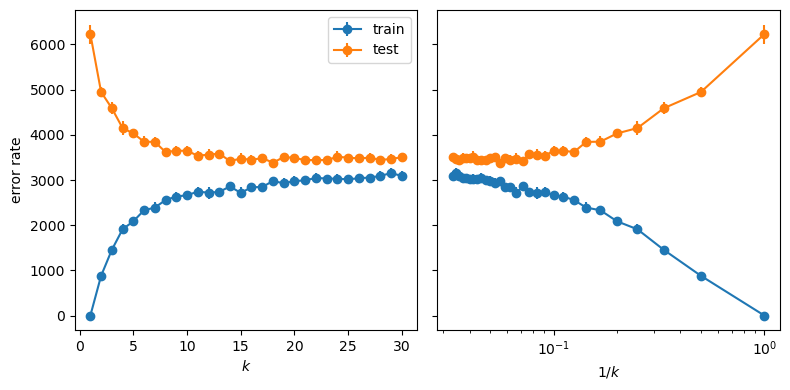

In [105]:
reps=25
max_k=30
train_results, test_results = evaluation(max_k=max_k, cv=BootstrapSplitter(reps, 0.6, random_state=0), data = diabetes.data, target = diabetes.target)
plot (max_k,train_results,test_results)

**Question 1.2: Evaluation for KNN Regressor California Housing Model**

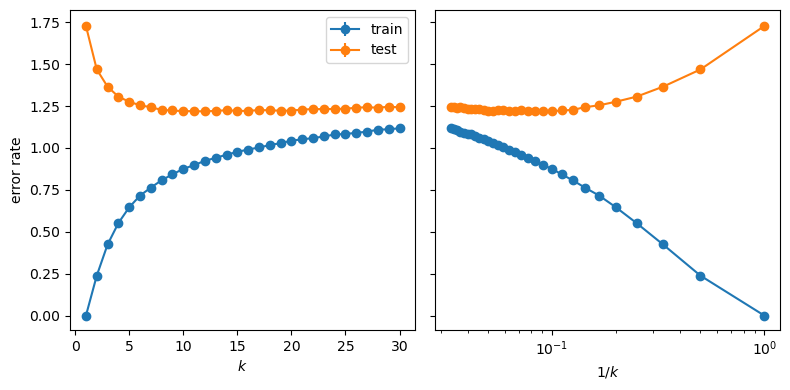

In [106]:
reps=25
max_k=30
train_results, test_results = evaluation(max_k=max_k, cv=BootstrapSplitter(reps, 0.6, random_state=0), data = california_housing.data, target = california_housing.target)
plot (max_k,train_results,test_results)

**Question 2.1: L Fold Cross Validation Model**

In [92]:
class LFold:
    def __init__(self, k, random_state=None): # ADD PARAMETERS AS REQUIRED
        self.k = k
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self, x=None, y=None, groups=None):
        return self.k
    
    def split(self, x, y=None, groups=None):
        # size per fold
        per_fold = len(x) // self.k
        # creates the array contaning [0..len(x)-1] which represents all indices available for selection
        indices_arr = np.arange(len(x))
        np.random.shuffle(indices_arr)
        for i in range (self.k):
            # slice the test idx based on the current fold
            test_idx = indices_arr [i*per_fold : i*per_fold + per_fold]
            # take every index before the current fold
            head = indices_arr [:i*per_fold]
            # take every index after the current fold
            tail = indices_arr [i*per_fold + per_fold:] 
            # concatenate the leftover array into our train idx array
            train_idx = np.concatenate((head,tail))
            yield train_idx, test_idx


**Question 2.2 Evaluation Model for L Fold Cross Validation Model**

In [190]:
from sklearn.model_selection import cross_validate

def evaluation_l_fold(max_k, cv,data,target):
    r = cv.get_n_splits()
    
    train_mean = np.zeros(shape=(r, max_k))
    train_std = np.zeros(shape=(r, max_k))
    train_con = np.zeros(shape=(r,max_k))
    test_mean = np.zeros(shape=(r, max_k))
    test_std = np.zeros(shape=(r, max_k))
    test_con = np.zeros(shape=(r, max_k))

    for k in range(1, max_k+1):
        knn = KnnRegressor(k)
        current_fold_test_score = []
        current_fold_train_score = []
        for i in range (r):
            cv_res = cross_validate(knn, data, target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
            current_fold_test_score.append(cv_res['test_score'])
            current_fold_train_score.append(cv_res['train_score'])
        test_mean[:, k-1] = np.mean(current_fold_test_score)
        test_std[:, k-1] = np.std(current_fold_test_score)
        train_mean[:, k-1] = np.mean(current_fold_train_score)
        train_std[:, k-1] = np.std(current_fold_train_score)
        train_std[:, k-1] = np.std(current_fold_train_score)
    return test_mean, test_std , train_mean, train_std

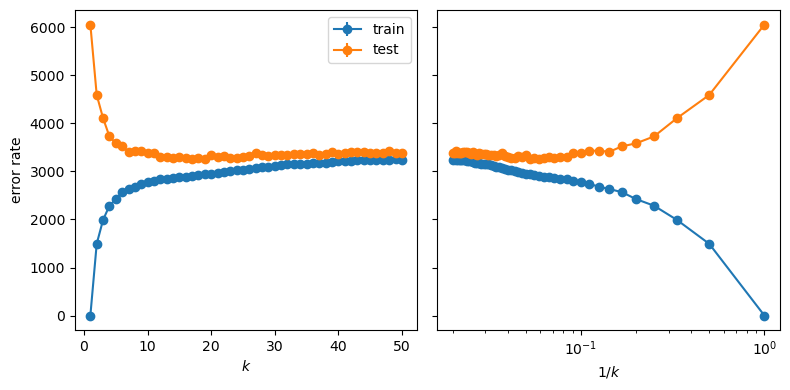

In [191]:
max_k = 50
test_mean, test_std , train_mean, train_std = evaluation_l_fold(max_k=max_k, cv=LFold(5, random_state=0),data = diabetes.data,target = diabetes.target)
plot (max_k,train_mean,test_mean)

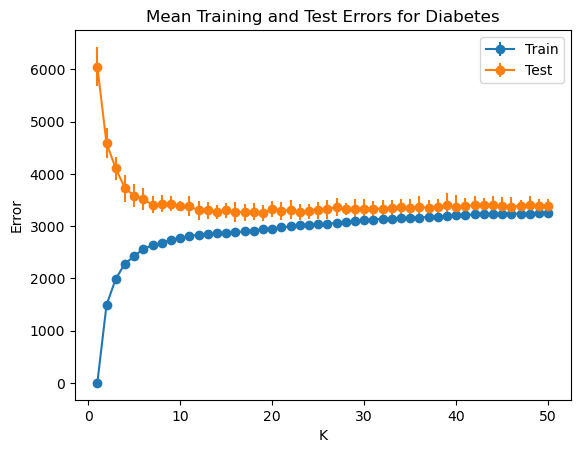

In [217]:
# def plot (max_k,train_results,test_results):
#     ks = np.arange(1, max_k+1)
#     _, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
#     z = (reps**0.5)/1.96
#     axs[0].errorbar(ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
#     axs[0].errorbar(ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
#     axs[0].legend()
#     axs[0].set_xlabel('$k$')
#     axs[0].set_ylabel('error rate')
#     axs[1].errorbar(1/ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
#     axs[1].errorbar(1/ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
#     axs[1].set_xscale('log')
#     axs[1].set_xlabel('$1/k$')
#     plt.show()


def plot_errors(max_k, test_mean, test_std , train_mean, train_std, dataset_name):
    # Compute confidence intervals using the formula you provided
    ks = np.arange(1, max_k+1)
    
    train_con = 1.96 * (np.array(train_std.mean(axis=0)))/train_mean.shape[0]
    test_con = 1.96 * (np.array(test_std.mean(axis=0)))/test_mean.shape[0]
    
    plt.errorbar(ks, train_mean.mean(axis=0), yerr = train_con, label='Train', marker='o')
    plt.errorbar(ks, test_mean.mean(axis=0), yerr = test_con, label='Test', marker='o')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f'Mean Training and Test Errors for {dataset_name}')
    plt.legend()
    plt.show()
    
plot_errors (max_k,test_mean, test_std , train_mean, train_std, 'Diabetes')

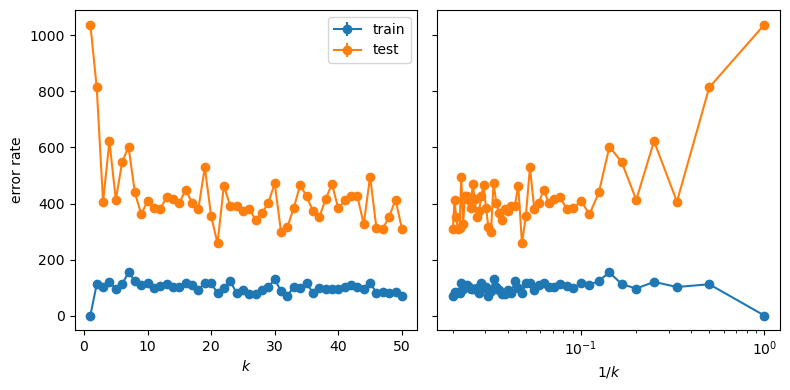

In [125]:
plot (max_k,train_std,test_std)

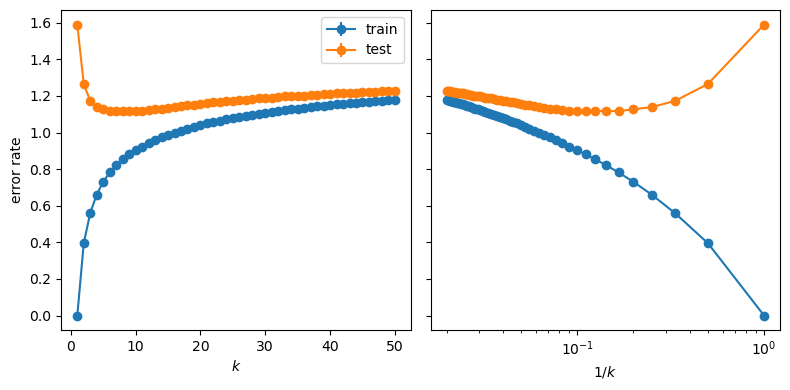

In [117]:
max_k = 50
test_mean, test_std , train_mean, train_std = evaluation_l_fold(max_k=max_k, cv=LFold(5, random_state=0),data = california_housing.data,target = california_housing.target)
plot (max_k,train_mean,test_mean)

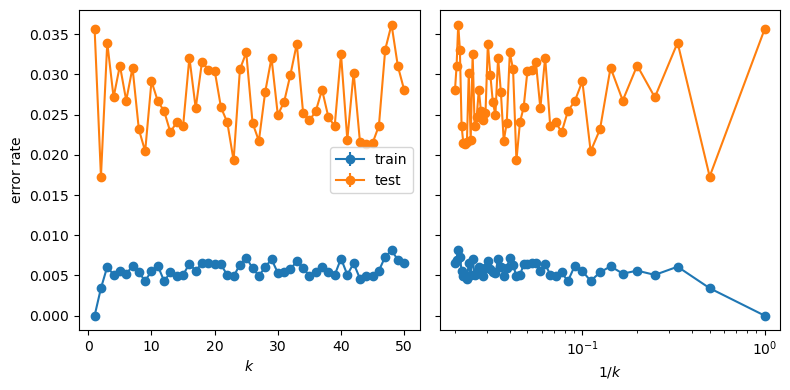

In [118]:
plot (max_k,train_std,test_std)

**Question 2.2 Evaluation Model for L Fold Cross Validation Model**

In [69]:
from sklearn.base import BaseEstimator

# class KnnRegressor(BaseEstimator):
#     def __init__(self,k): # ADD PARAMETERS AS REQUIRED
#         self.k = k
        
#     def fit(self, x, y):
#         self.y_train_ = y
#         self.x_train_kdtree_ = KDTree(x)
#         return self
    
#     def predict(self, x):
#         _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
#         neighbours = neighbours.reshape(len(x), self.k)
#         neighbour_labels = self.y_train_[neighbours]
#         m = pmean(neighbour_labels, axis=1, keepdims=False, p = 1)
#         return m

class KnnRegressorCV(BaseEstimator):
    def __init__(self, ks=list(range(1, 21)), cv=LFold(5)):
    # YOUR CODE HERE
        self.ks = ks
        self.cv = cv
        
    def fit(self, x, y):
    # YOUR CODE HERE
        self.k = 0 
        r = self.cv.get_n_splits()
        best_k = []
        current_best_k = 0
        current = 0
        for idx_train, idx_test in self.cv.split(x):
            best_test = math.inf
            current_best_k = 0
            # for every k, loop every fold combination of this current fold
            for i in range (len(ks)):
                knn = KnnRegressor(ks[i])
                for j in range (r):
                    current_fold_test = []
                    current_fold_train = []
                    cv_res = cross_validate(knn, x[idx_train], y[idx_train], cv=self.cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
                    current_fold_train.append(cv_res['train_score'])
                    current_fold_test.append(cv_res['test_score'])
                current_fold_train_score = np.mean(current_fold_train)
                current_fold_test_score = np.mean(current_fold_test)
                if current_fold_test_score < best_test:
                    current_best_k = ks[i]
                    best_test = current_fold_test_score
            best_k.append(current_best_k)
            current += 1
        self.k = math.floor(np.mean(best_k))
        print (self.k)
        self.y_train_ = y
        self.x_train_kdtree_ = KDTree(x)
        print (best_test)
        print (self.k)
        return self
                
                
    def predict(self, x):
    # YOUR CODE HERE
        _, neighbours = self.x_train_kdtree_.query(x, k=self.k)
        neighbours = neighbours.reshape(len(x), self.k)
        neighbour_labels = self.y_train_[neighbours]
        m = pmean(neighbour_labels, axis=1, keepdims=False, p = 1)
        return m

In [70]:
knn_cv = KnnRegressorCV()
knn_cv.fit(x_train_diabetes,y_train_diabetes)
y_hat_test_diabetes = knn_cv.predict(x_test_diabetes)
y_hat_train_diabetes = knn_cv.predict(x_train_diabetes)
error_rate(y_train_diabetes, y_hat_train_diabetes), error_rate(y_test_diabetes, y_hat_test_diabetes)

18
3317.200252047889
18


(58.33989450971446, 54.11587523224377)

In [72]:
knn_cv2 = KnnRegressorCV()
knn_cv2.fit(x_train_cali,y_train_cali)
y_hat_test_cali = knn_cv2.predict(x_test_cali)
y_hat_train_cali = knn_cv2.predict(x_train_cali)
error_rate(y_train_cali, y_hat_train_cali), error_rate(y_test_cali, y_hat_test_cali)

10
1.182716121454519
10


(0.9599509799467973, 1.0894768645457906)

In [ ]:
def evaluation(max_k, cv, data, target):
    r = cv.get_n_splits()
    test_results = np.zeros(shape=(r, max_k))
    train_results = np.zeros(shape=(r, max_k))
    for k in range(1, max_k+1):
        knn = KnnRegressorCV()
        cv_res = cross_validate(knn,data,target, cv=cv, return_train_score=True, scoring=make_scorer(mean_squared_error))
        test_results[:, k-1] = cv_res['test_score']
        train_results[:, k-1] = cv_res['train_score']

    return train_results, test_results